# inspect single model


In [1]:
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# default params
taskargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}

schargs = {
   'concentration':1.4,
   'stickiness_wi':3,
   'stickiness_bt':3,
   'sparsity':0.11,
   'pvar': 0,
   'lrate':1,
   'lratep':1,
   'decay_rate':1,
}

semargs = {
  'beta2':False,
  'skipt1':True,
  'ppd_allsch':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':taskargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_305.000-stickiness_wi_680.000-stickiness_bt_480.000-sparsity_1.000-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000'

In [3]:
## timestamp and dir for saving
import os
tstamp = time.perf_counter_ns()
figdir = 'figures/single_model_nb/%s-%i/'%(param_str,tstamp)
os.makedirs(figdir)

### main

In [4]:
ns = 50
L = []
condL = ['blocked','interleaved',
         'early','middle','late'
        ]
exp_batch_data = run_batch_exp_curr(ns,args,condL) # [curr,seeds,{data}]


In [5]:
## accuracy
# bads = get_bad_seed(exp_batch_data,max_splits=50)
# goods = np.setdiff1d(np.arange(ns),bads)
batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
mean_acc = batch_acc.mean(1)
test_acc = mean_acc[:,-40:].mean(1) # curr  
test_acc

array([0.44225, 0.508  , 0.495  , 0.51025, 0.48775])

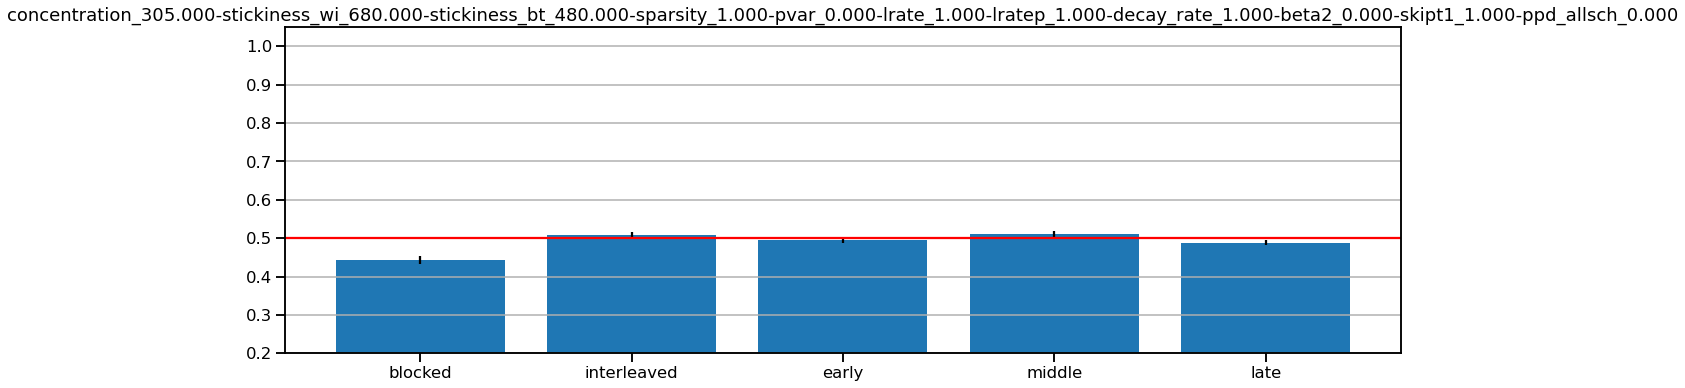

In [6]:
plt.figure(figsize=(20,6))
M = mean_acc[:,-40:].mean(1)
S = mean_acc[:,-40:].std(1)/np.sqrt(ns)
plt.bar(condL,test_acc,yerr=S)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')
plt.title(param_str)
plt.grid(True,axis='y')
plt.savefig(figdir+'Mtestacc.png')

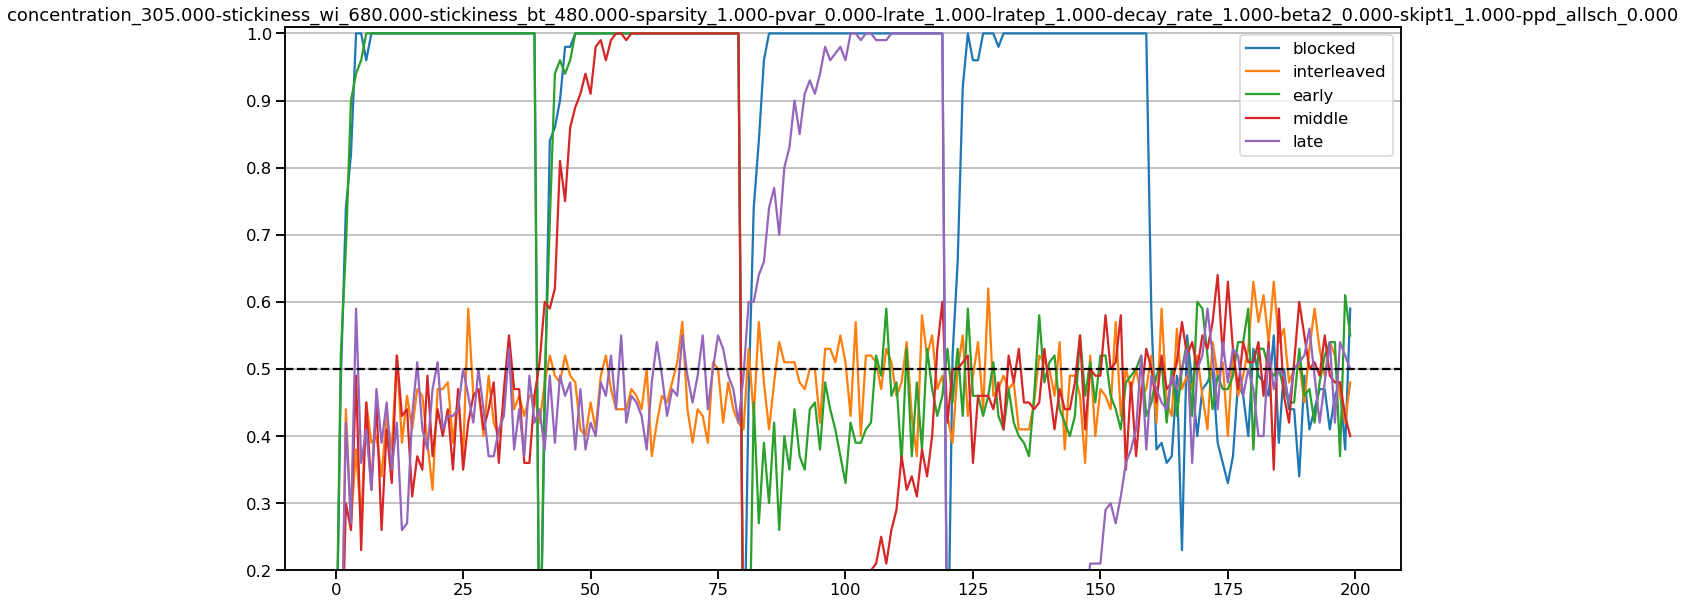

In [7]:
plt.figure(figsize=(20,10))
for idx in range(len(condL)):
  plt.plot(mean_acc[idx],label=condL[idx])
plt.legend()
plt.axhline(0.5,c='k',ls='--')
plt.ylim(0.2,1.01)
plt.title(param_str)
plt.grid(True,axis='y')
plt.savefig(figdir+'acc-by-time.png')


# analysis of model state

<ipython-input-8-bd4a3ae9223f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+condL)


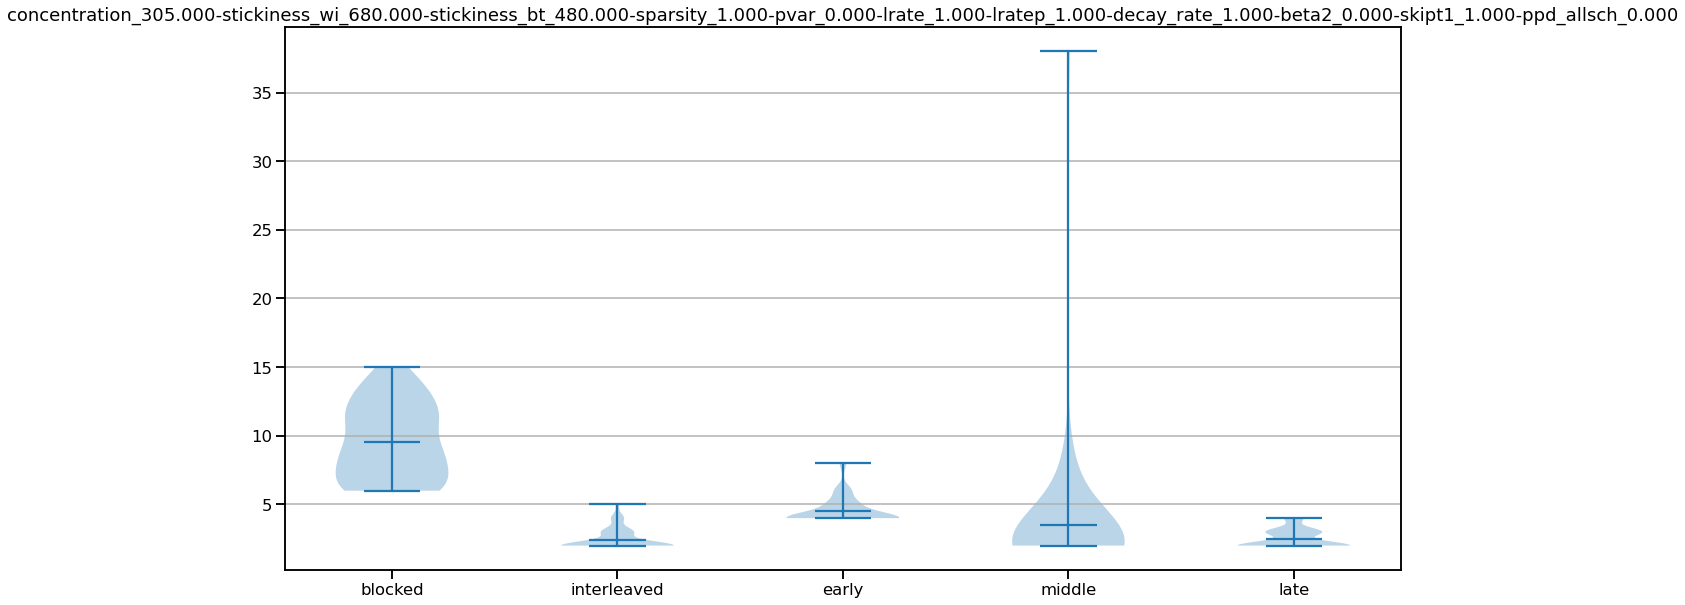

In [8]:
## count number of schemas used
def count_num_schemas(exp_data):
  """ 
  """
  L = []
  for curr_idx in range(5):
    num_schemas_used = [
      len(np.unique(exp_data[curr_idx][i]['zt'][:,:-1].flatten())
         ) for i in range(ns)
    ]
    L.append(num_schemas_used)
  nschemas = np.array(L)
  return nschemas


nschemas = count_num_schemas(exp_batch_data)
M = nschemas.mean(1)
S = nschemas.std(1)
plt.figure(figsize=(20,10))
plt.title('number schemas used')
plt.violinplot(nschemas.T,np.arange(5),showmeans=True)
# plt.bar(condL,M,zorder=-100,alpha=0.1)
ax = plt.gca()
ax.set_xticklabels([0]+condL)
plt.grid(True,axis='y')
plt.title(param_str)
plt.savefig(figdir+'nsch-violin.png')

In [9]:
curr_idx = 0
seed_idx = 1
## 
prior = unpack_data(exp_batch_data,
        dtype='prior')[curr_idx][seed_idx]
like = unpack_data(exp_batch_data,
        dtype='like')[curr_idx][seed_idx]
post = unpack_data(exp_batch_data,
        dtype='post')[curr_idx][seed_idx]
post.shape

(200, 5, 13)

### infered schema

In [10]:
curr = 1
for seed in range(10):
  print('seed',seed)
  zt = exp_batch_data[curr][seed]['zt']
  st = exp_batch_data[curr][seed]['exp']

  prior = unpack_data(exp_batch_data,
          dtype='prior')[curr][seed] # trial,tstep,sch
  like = unpack_data(exp_batch_data,
          dtype='like')[curr][seed]
  post = unpack_data(exp_batch_data,
          dtype='post')[curr][seed]


  for i in range(200):
    
    print("t%.2i"%i,zt[i],st[i],
  #        post[i,:,1],
  #        post[i,:,2]
         )

seed 0
t00 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t01 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t02 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t03 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t04 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t05 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t06 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t07 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t08 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t09 [ 0. -1.  0.  1. -1.] [0 2 4 5 8]
t10 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t11 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t12 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t13 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t14 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t15 [ 1. -1.  2.  2. -1.] [0 2 4 5 8]
t16 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t17 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t18 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t19 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t20 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t21 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t22 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t23 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t24 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t25 [ 2. -1.  2.  2. -1.] [0 2 4 5 8]
t26 [

t22 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t23 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t24 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t25 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t26 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t27 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t28 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t29 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t30 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t31 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t32 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t33 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t34 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t35 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t36 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t37 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t38 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t39 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t40 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t41 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t42 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t43 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t44 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t45 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t46 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t47 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t48 [ 0. -1.

t40 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t41 [ 2. -1.  2.  2. -1.] [0 2 4 5 8]
t42 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t43 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t44 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t45 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t46 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t47 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t48 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t49 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t50 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t51 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t52 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t53 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t54 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t55 [ 2. -1.  2.  2. -1.] [0 2 4 5 8]
t56 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t57 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t58 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t59 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t60 [ 2. -1.  2.  2. -1.] [0 1 3 5 7]
t61 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t62 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t63 [ 2. -1.  2.  2. -1.] [0 2 4 5 8]
t64 [ 2. -1.  2.  2. -1.] [0 1 4 6 8]
t65 [ 2. -1.  2.  2. -1.] [0 2 3 6 7]
t66 [ 2. -1.

t133 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t134 [ 1. -1.  1.  1. -1.] [0 1 3 5 7]
t135 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t136 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t137 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t138 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t139 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t140 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t141 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t142 [ 1. -1.  1.  1. -1.] [0 1 3 5 7]
t143 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t144 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t145 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t146 [ 1. -1.  1.  1. -1.] [0 1 3 5 7]
t147 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t148 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t149 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t150 [ 1. -1.  1.  1. -1.] [0 1 3 5 7]
t151 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t152 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t153 [ 1. -1.  1.  1. -1.] [0 2 3 6 7]
t154 [ 1. -1.  1.  1. -1.] [0 1 4 6 8]
t155 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t156 [ 1. -1.  1.  1. -1.] [0 1 3 5 7]
t157 [ 1. -1.  1.  1. -1.] [0 2 4 5 8]
t158 [ 1. -1.  1.  1. -1.

t00 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t01 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t02 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t03 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t04 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t05 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t06 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t07 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t08 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t09 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t10 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t11 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t12 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t13 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t14 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t15 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t16 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t17 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t18 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t19 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t20 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t21 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t22 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t23 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t24 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t25 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t26 [ 0. -1.

t25 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t26 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t27 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t28 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t29 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t30 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t31 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t32 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t33 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t34 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t35 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t36 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t37 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t38 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t39 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t40 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t41 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t42 [ 0. -1.  0.  0. -1.] [0 1 4 6 8]
t43 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t44 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t45 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t46 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t47 [ 0. -1.  0.  0. -1.] [0 2 3 6 7]
t48 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t49 [ 0. -1.  0.  0. -1.] [0 2 4 5 8]
t50 [ 0. -1.  0.  0. -1.] [0 1 3 5 7]
t51 [ 0. -1.

# posterior, likelihood, prior

In [11]:
def plt_prdata(dtype='post',schL=[0,1],curr_idx=0,seed_idx=0):
  """ 
  plots probability data (post,prior,like) 
  of at most 3 timesteps of 4 schemas
  NB single seed
  """
  # load data
  prdata = unpack_data(exp_batch_data,
          dtype=dtype)[curr_idx][seed_idx]
  # setup plots
  f,axar = plt.subplots(3,4,figsize=(20,10),sharex=True,sharey=True)
  # loop over timesteps and schema
  for ti,tstep in enumerate([0,2,3]):
    for si,sch in enumerate(schL):
      axar[0,si].set_title('sch%i'%sch)
      ax = axar[ti,si]
      # plot
      ax.plot(prdata[:,tstep,sch])
      for k in np.arange(0,200,40):
        ax.axvline(k,c='k',lw=0.5)
    axar[ti,0].set_ylabel('tstep%i'%tstep)
  title = '%s-%s'%(dtype,param_str)
  plt.suptitle(title)
  plt.savefig(figdir+'%s.png'%dtype)



1


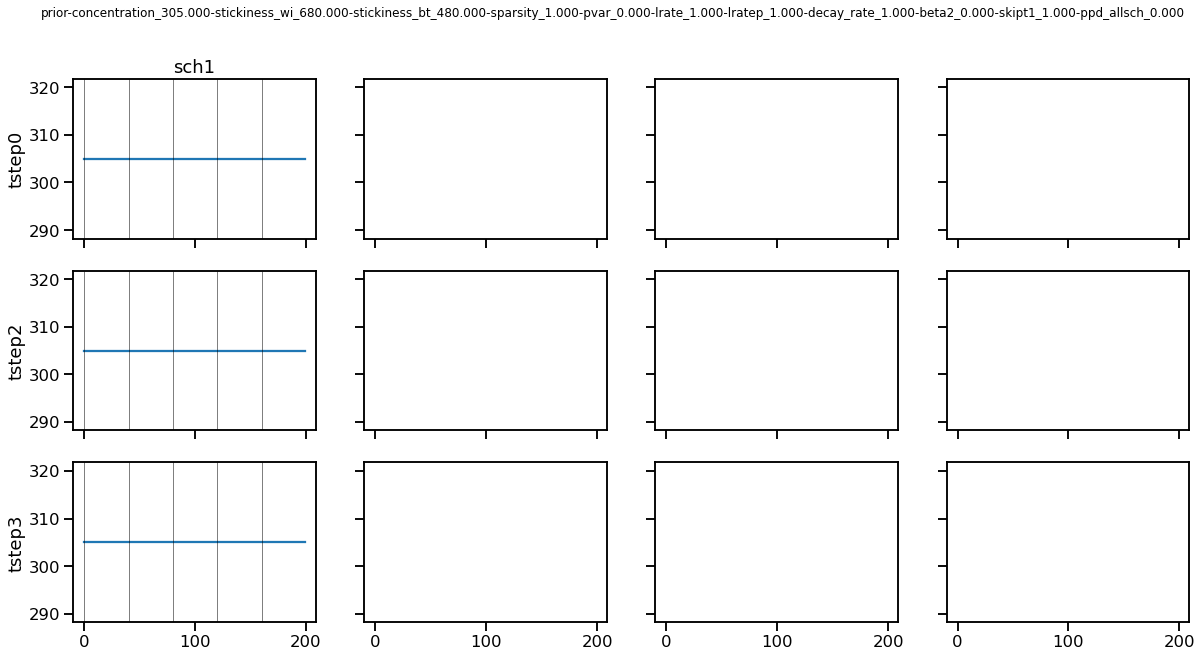

In [12]:
curr_idx=3
seed_idx=1
nsch = len(np.unique(exp_batch_data[curr_idx][seed_idx]['zt']))-1
print(nsch)
schL = [1]
plt_prdata('prior',schL,curr_idx,seed_idx)

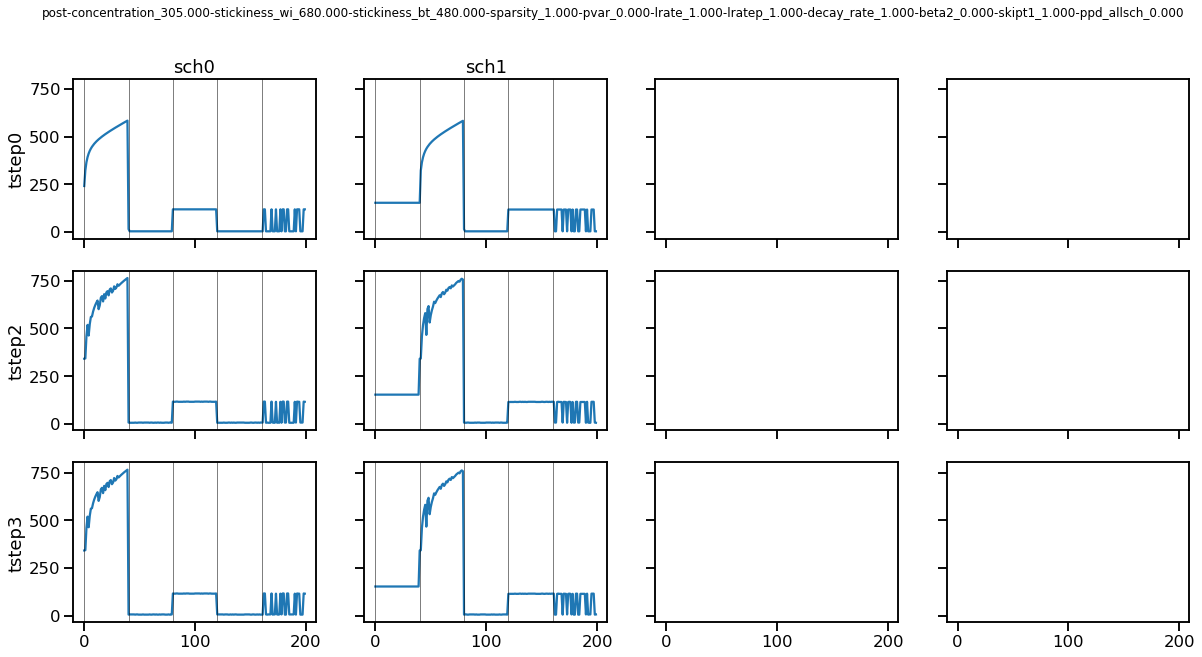

In [13]:
plt_prdata('post')

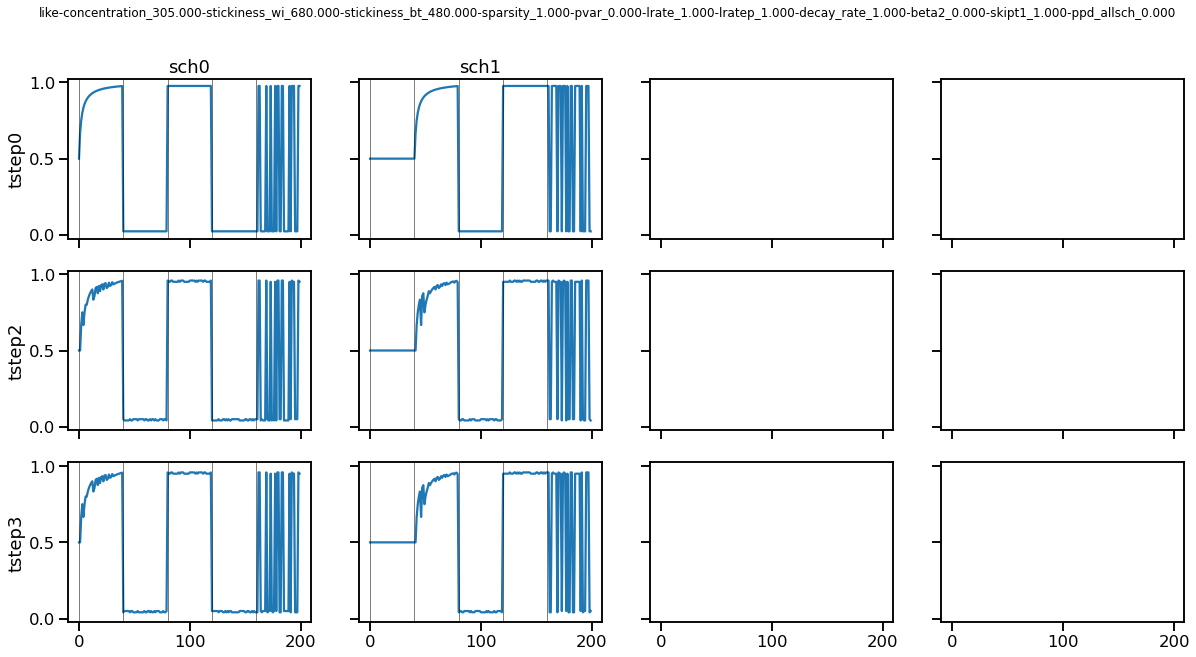

In [14]:
plt_prdata('like')

In [15]:
def get_bad_seed(exp_batch_data,max_splits=10):
  bad_seed_L = []
  for curr_idx in range(5):
    for seed_idx in range(ns):
      max_sch = np.max(exp_batch_data[curr_idx][seed_idx]['zt'])
      if max_sch>max_splits:
        bad_seed_L.append(seed_idx)
  return list(set(bad_seed_L))
get_bad_seed(exp_batch_data,max_splits=10)

[32, 1, 2, 34, 7, 12, 13, 48, 49, 23]

### adjusted rand score

In [16]:
def calc_adjrand(exp_batch_data):
  arscores = -np.ones([len(condL),ns,3])
  for curr_idx in range(5):
    for seed_idx in range(ns):
      for t_idx,tstep in enumerate([0,2,3]):
        arscores[curr_idx,seed_idx,t_idx] = adjusted_rand_score(
          exp_batch_data[curr_idx][seed_idx]['exp'][:,1],
          exp_batch_data[curr_idx][seed_idx]['zt'][:,tstep]
        )
  return arscores.mean(1)

calc_adjrand(exp_batch_data)

array([[ 3.21100160e-01,  3.21156202e-01,  3.21182468e-01],
       [-2.19923416e-04, -1.48430258e-04, -1.10591559e-04],
       [ 1.56037873e-01,  1.55975397e-01,  1.55998508e-01],
       [ 2.56139103e-02,  2.63006943e-02,  2.63196102e-02],
       [-3.47050344e-04, -3.34180782e-04, -2.56390191e-04]])

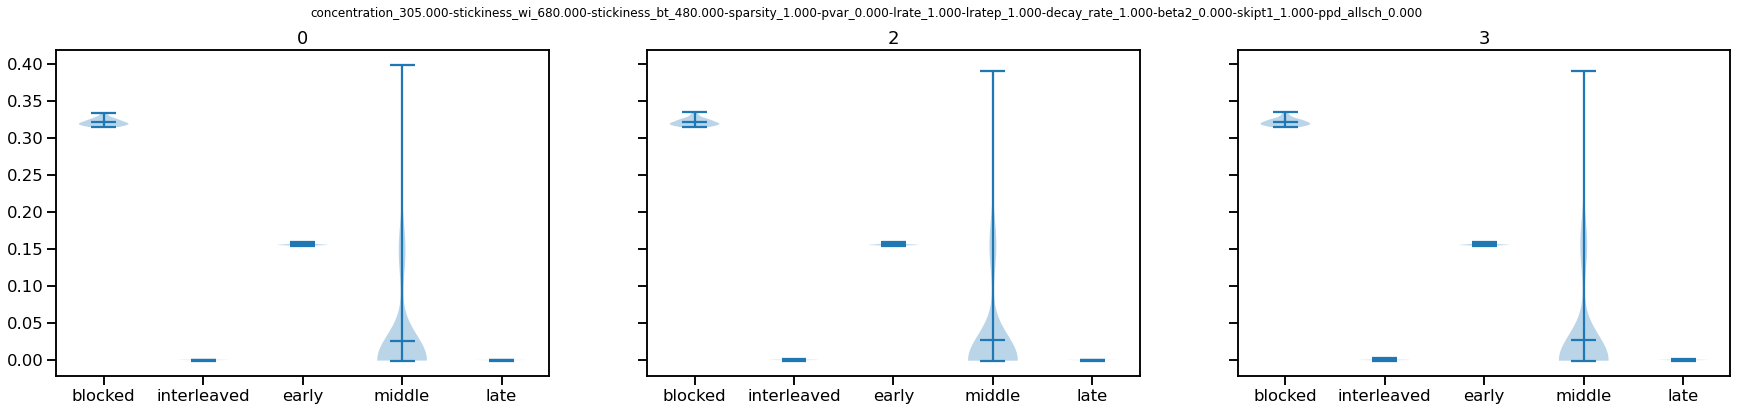

In [17]:
f,axar=plt.subplots(1,3,figsize=(30,6),sharey=True)
for t in range(3):
  ax=axar[t]
  ax.violinplot(arscores[:,:,t].T,showextrema=1,showmeans=1)
  ax.set_xticks(np.arange(1,6))
  ax.set_xticklabels(condL)
  ax.set_title(['0','2','3'][t])
plt.suptitle(param_str)
plt.savefig(figdir+'adjrand')